In [1]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append("../python/")
from dataset_utils import parse_filename

In [2]:
pd.options.display.max_colwidth = 200

liepa_path = Path("../data/raw/")

In [4]:
with open(liepa_path / "etc" / "corpus-data.json") as f:
    corpus_data = json.load(f)

In [5]:
PHRASES_TO_EXCLUDE = [
    "+BREATH+",
    "+COUGH+",
    "+LAUGH+",
    "+SMACK+",
    "+AH+",
    "+EH+",
    "+MM+",
    "+GARBAGE+",
    "+NOISE+",
]

In [6]:
def process_media(segment_name: str, segments: list):
    metadata = []

    for index, segment in enumerate(segments, start=1):
        length = segment["len"]

        phrase = segment["val"].strip()
        audio_name = f"{segment_name}_{index:06}.wav"

        if phrase not in PHRASES_TO_EXCLUDE:
            metadata.append(
                {
                    "file_name": audio_name,
                    "sentence": phrase,
                    "length": length,
                    "language": "lt",
                }
            )

    return metadata

In [7]:
all_segments = []
for _, value in corpus_data.items():
    media_subpath = value["media"]["path"].split("/")[-1].rstrip(".wav")
    tiers = value.get("tiers", None)

    if tiers is None:
        segments = value["speech"]
        all_segments.extend(process_media(media_subpath, segments))
    else:
        for tier_name in tiers:
            segments = value["speech"][tier_name]
            if isinstance(segments, dict):
                segments = [segments]
            all_segments.extend(process_media(tier_name, segments))

In [8]:
segments_df = pd.DataFrame(all_segments)

segments_df[
    [
        "lossiness",
        "speech_type",
        "source_type",
        "speaker_gender",
        "speaker_age",
        "speaker_id",
        "recording_id",
        "sentence_id",
    ]
] = segments_df["file_name"].apply(parse_filename).tolist()
segments_df["sentence_len"] = segments_df["sentence"].apply(len)

In [9]:
segments_df.groupby(["speech_type"])["length"].sum() / 3600 / 1000

speech_type
read           855.251349
spontaneous     84.718568
Name: length, dtype: float64

In [10]:
filtered_df = segments_df[
    (segments_df["speech_type"] == "read")
    & (segments_df["speaker_age"] != "0-12")
    & (segments_df["speaker_age"] != "13-17")
    & (segments_df["source_type"].isin(["audiobook", "dictaphone", "studio"]))
    & (segments_df["length"] >= 1000)
    & (segments_df["length"] <= 15000)
].reset_index(drop=True)

In [11]:
filtered_df["speaker_id"].nunique()

1794

In [78]:
# def extract_segment_ends(segments):
#     ends = []
#     if isinstance(segments, dict) and "sid" in segments:
#         segments = [segments]
#     if isinstance(segments, list):
#         for seg in segments:
#             ends.append((seg["beg"], seg["end"]))
#     elif isinstance(segments, dict):
#         for v in segments.values():
#             if isinstance(v, list):
#                 for seg in v:
#                     ends.append((seg["beg"], seg["end"]))
#             else:
#                 ends.append((v["beg"], v["end"]))
#     ends = sorted(ends, key=lambda x: x[0])
#     return ends


# for row in tqdm(meta_df.itertuples(), total=len(meta_df), desc="Checking overlaps"):
#     # check if speech segments overlap with noise segments
#     speech_segments = extract_segment_ends(row.speech)
#     noise_segments = extract_segment_ends(row.noise)

#     for speech_beg, speech_end in speech_segments:
#         for noise_beg, noise_end in noise_segments:
#             if not (speech_end <= noise_beg or speech_beg >= noise_end):
#                 overlap_len = min(speech_end, noise_end) - max(speech_beg, noise_beg)
#                 if overlap_len > 15:
#                     print(f"Overlap in file {row.Index}: size {overlap_len} ms")
#             if speech_end <= noise_beg:
#                 break

In [43]:
length_per_speaker

total_length  rank
speaker_gender speaker_id                    
female         VP013          65.238683     1
               VP154          59.867383     2
               VP466          58.378450     3
               AS221          56.936500     4
               VP038          56.693850     5
...                                 ...   ...
male           IS416           0.525550   687
               VP128           0.421033   688
               IS335           0.373233   689
               IS253           0.362933   690
               VP129           0.351933   691

[1794 rows x 2 columns]

In [50]:
length_per_speaker

total_length  rank
speaker_gender speaker_id                    
female         VP013          65.238683     1
               VP154          59.867383     2
               VP466          58.378450     3
               AS221          56.936500     4
               VP038          56.693850     5
...                                 ...   ...
male           IS416           0.525550   687
               VP128           0.421033   688
               IS335           0.373233   689
               IS253           0.362933   690
               VP129           0.351933   691

[1794 rows x 2 columns]

In [74]:
# length_per_speaker.sort_values("total_length", ascending=False).groupby("speaker_gender").head(15)

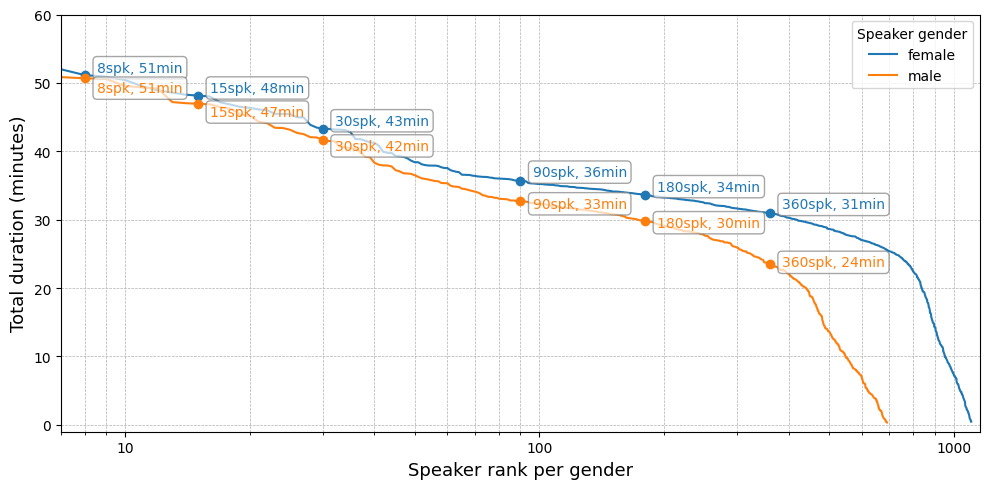

In [183]:
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

# plot rank per gender on X axis
# and duration on Y axis

length_per_speaker = filtered_df.groupby(["speaker_gender", "speaker_id"])["length"].sum().to_frame(name="total_length").reset_index()
length_per_speaker["total_length"] /= 1000 * 60  # convert to minutes
length_per_speaker.sort_values(by=["speaker_gender", "total_length"], ascending=[True, False], inplace=True)
length_per_speaker["rank"] = length_per_speaker.groupby("speaker_gender").cumcount() + 1

plt.figure(figsize=(10, 5))
for gender, gender_df in length_per_speaker.groupby("speaker_gender"):
    plt.plot(
        gender_df["rank"],
        gender_df["total_length"],
        marker="",
        linestyle="-",
        label=gender,
    )
    # Add visible points at ranks 15, 30, 90
    for rank in [8, 15, 30, 90, 180, 360]:
        point = gender_df[gender_df["rank"] == rank]
        x_val = point["rank"].values[0]
        y_val = point["total_length"].values[0]
        color = plt.gca().lines[-1].get_color()
        plt.plot(
            x_val,
            y_val,
            marker="o",
            markersize=6,
            color=color,
        )
        # Add text annotation with coordinates
        plt.annotate(
            f"{x_val}spk, {y_val:.0f}min",
            xy=(x_val * 1.03, y_val * (0.99 if gender == "female" else 0.94)),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7),
            color=color,
        )

plt.xlabel("Speaker rank per gender", fontsize=13)
plt.ylabel("Total duration (minutes)", fontsize=13)
plt.xscale("log")
plt.xlim(7, length_per_speaker["rank"].max() * 1.05)
plt.ylim(-1, 60)
# Format X axis to show regular numbers instead of exponents
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
# ax.xaxis.get_major_formatter().set_scientific(False)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.legend(title="Speaker gender", fontsize=10)
plt.savefig("../latex/paper/figures/liepa_speaker_duration.png", dpi=300)

In [12]:
df1 = filtered_df.groupby(["speech_type"]).aggregate(
    {
        "length": ["mean", "max", "sum"],
        "sentence_len": ["mean", "max"],
        "speaker_id": pd.Series.nunique,
        "file_name": "count",
    }
)
df1
# print(df1.to_latex())

length                    sentence_len      speaker_id  \
                    mean    max         sum         mean  max    nunique   
speech_type                                                                
read         2770.690323  14954  2604069319    41.139483  296       1794   

            file_name  
                count  
speech_type            
read           939863

In [91]:
df1 = filtered_df.groupby(["speech_type", "source_type"]).aggregate(
    {
        "length": ["mean", "max", "sum"],
        "sentence_len": ["mean", "max"],
        "speaker_id": pd.Series.nunique,
        "file_name": "count",
    }
)
df1
# print(df1.to_latex())

length                    sentence_len       \
                                mean    max         sum         mean  max   
speech_type source_type                                                     
read        audiobook    2588.343493  12732    87553307    39.447703  214   
            dictaphone   2643.412331  14941   677733914    37.123415  270   
            studio       2830.415251  14954  1838782098    42.812519  296   

                        speaker_id file_name  
                           nunique     count  
speech_type source_type                       
read        audiobook           50     33826  
            dictaphone         453    256386  
            studio            1303    649651

In [100]:
2604069319 / 3600 / 1000

723.3525886111112

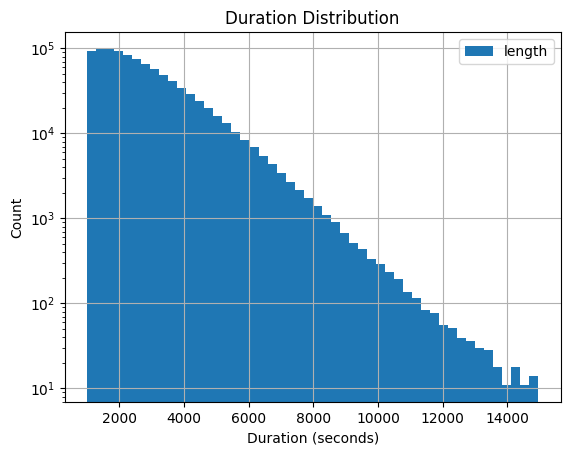

In [110]:
from matplotlib import pyplot as plt

filtered_df.plot.hist(
    y="length",
    log=True,
    title="Duration Distribution",
    bins=50,
)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid()
plt.show()
# plt.savefig("plots/liepa_duration_distribution.png")

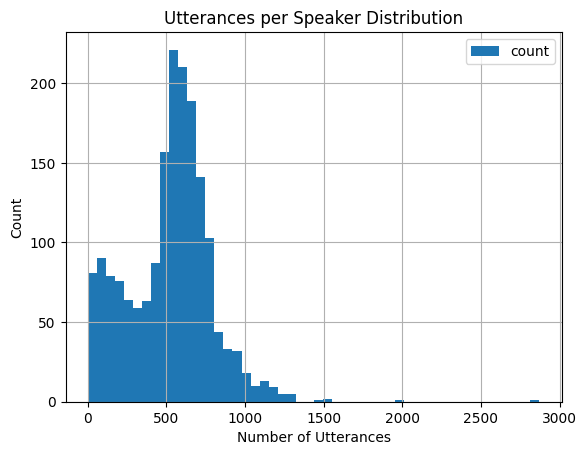

In [105]:
counts_df = filtered_df.groupby("speaker_id").aggregate(
    {"file_name": "count", "length": "sum", "sentence_len": ["mean", "sum"]}
)
counts_df.plot.hist(
    y="file_name", log=False, title="Utterances per Speaker Distribution", bins=50
)
plt.xlabel("Number of Utterances")
plt.ylabel("Count")
plt.grid()
plt.show()
# plt.savefig("plots/liepa_utterances_per_speaker_distribution.png")

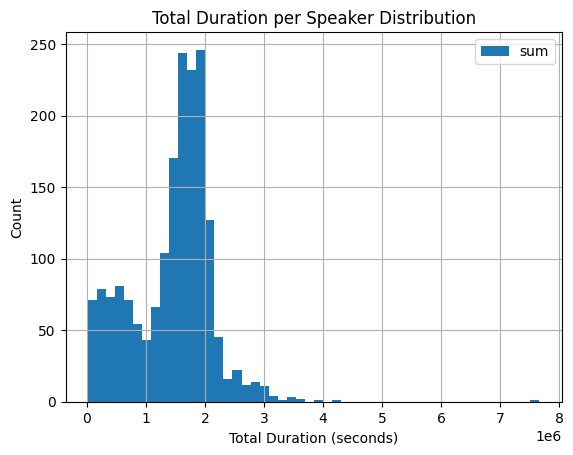

In [112]:
counts_df.plot.hist(
    y="length", log=False, title="Total Duration per Speaker Distribution", bins=50
)
plt.xlabel("Total Duration (seconds)")
plt.ylabel("Count")
plt.grid()
plt.show()
# plt.savefig("plots/liepa_total_duration_per_speaker_distribution.png")

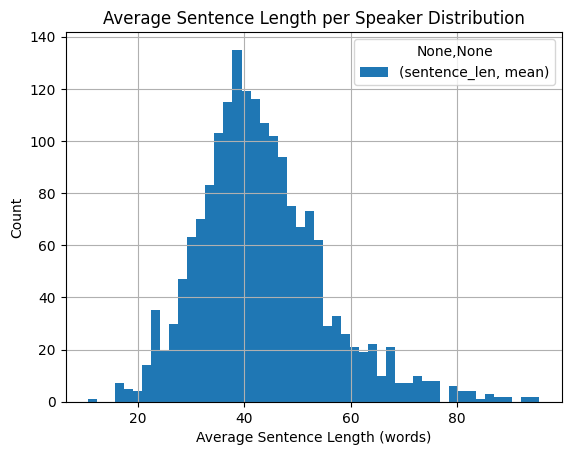

In [114]:
counts_df.plot.hist(
    y=("sentence_len", "mean"),
    log=False,
    title="Average Sentence Length per Speaker Distribution",
    bins=50,
)
plt.xlabel("Average Sentence Length (words)")
plt.ylabel("Count")
plt.grid()
plt.show()
# plt.savefig("plots/liepa_average_sentence_length_per_speaker_distribution.png")

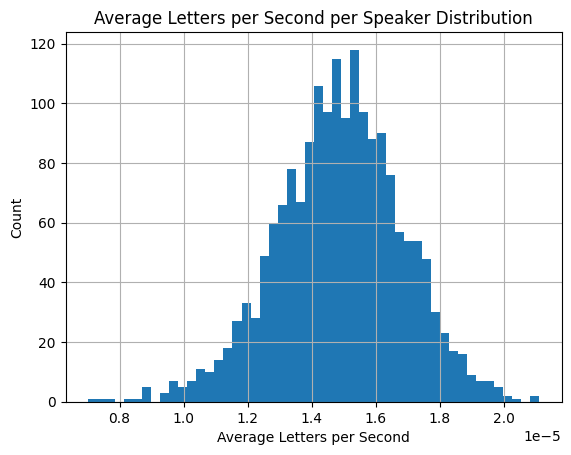

In [118]:
(counts_df[("sentence_len", "sum")] / 1000 / counts_df[("length", "sum")]).plot.hist(
    log=False, title="Average Letters per Second per Speaker Distribution", bins=50
)
plt.xlabel("Average Letters per Second")
plt.ylabel("Count")
plt.grid()
plt.show()
# plt.savefig("plots/liepa_average_letters_per_second_per_speaker_distribution.png")

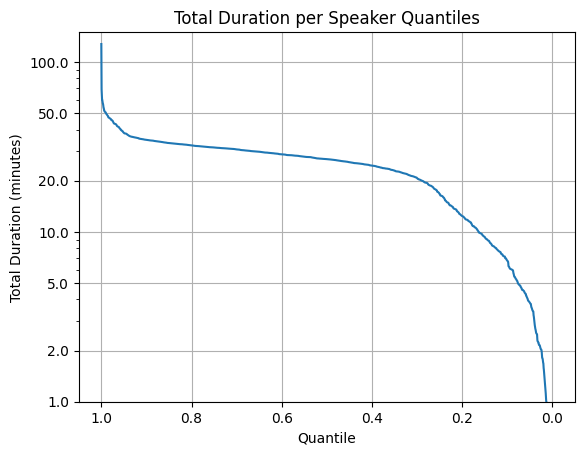

In [ ]:
quantiles = counts_df[("length", "sum")].quantile(np.arange(0, 1.0001, 0.0001))
plt.plot(
    quantiles.index,
    quantiles.values / 1000 / 60,
    # marker=".",
)
plt.xlim(1.05, -0.05)
plt.title("Total Duration per Speaker Quantiles")
# log axis for y
plt.yscale("log")
plt.xlabel("Quantile")
yr = np.array([1, 2, 5, 10, 20, 50, 100])
plt.yticks(yr, labels=[f"{y:.1f}" for y in yr])
plt.ylim(1, 150)
plt.ylabel("Total Duration (minutes)")
plt.grid()
plt.show()
# plt.savefig("plots/liepa_total_duration_per_speaker_quantiles.png")

In [131]:
# counts_df

In [28]:
speaker_counts_df = (
    filtered_df
    # calculate total count and duration per speaker
    .groupby(["speaker_gender", "speaker_id"])
    .agg(total_utterances=("sentence", "count"), total_duration=("duration", "sum"))
    .reset_index()
    .sort_values(by=["total_duration"], ascending=False)
)

In [29]:
selected_speakers = {}

for n_per_gender in [15, 30, 90]:
    selected_speakers_df = speaker_counts_df.groupby("speaker_gender").head(
        n_per_gender
    )
    selected_speakers[n_per_gender] = sorted(
        selected_speakers_df["speaker_id"].to_list()
    )

    assert all(
        set(selected_speakers[n_per_gender]).issuperset(other_selected_speakers)
        for _, other_selected_speakers in selected_speakers.items()
    )
    print(f"\n=== n_per_gender = {n_per_gender} ===")
    print(
        f"  Minimum count of utterances for selected speakers: "
        f"{selected_speakers_df['total_utterances'].min()}"
    )
    print(
        f"  Minimum total duration (s) for selected speakers: "
        f"{selected_speakers_df['total_duration'].min()}"
    )


=== n_per_gender = 15 ===
  Minimum count of utterances for selected speakers: 757
  Minimum total duration (s) for selected speakers: 2954.8615999999997

=== n_per_gender = 30 ===
  Minimum count of utterances for selected speakers: 427
  Minimum total duration (s) for selected speakers: 2614.5224

=== n_per_gender = 90 ===
  Minimum count of utterances for selected speakers: 427
  Minimum total duration (s) for selected speakers: 2040.5544


In [30]:
def sample_duration_per_speaker(df, selected_speakers, seconds_per_speaker):
    selected_df = df[df["speaker_id"].isin(selected_speakers)]
    sampled_dfs = []
    for speaker_id in selected_speakers:
        speaker_df = selected_df[selected_df["speaker_id"] == speaker_id]
        speaker_df = speaker_df.sample(
            frac=1, random_state=42
        )  # shuffle rows for randomness
        cumulative_duration = (
            speaker_df["duration"].cumsum() - speaker_df["duration"]
        )  # include one more utterance
        speaker_sampled_df = speaker_df[cumulative_duration <= seconds_per_speaker]
        sampled_dfs.append(speaker_sampled_df)
    return pd.concat(sampled_dfs, ignore_index=True)

In [ ]:
for n_per_gender in [15, 30, 90]:
    print(f"\n=== n_per_gender = {n_per_gender} ===")
    duration_per_speaker = 22.5 * 3600 / (n_per_gender * 2)
    sample_df = sample_duration_per_speaker(
        filtered_df, selected_speakers[n_per_gender], duration_per_speaker
    )
    print(f"  Total sampled duration (minutes): {sample_df['duration'].sum() / 60:.3f}")
    print(
        f"  Min/max duration per speaker (minutes): "
        f"{sample_df.groupby('speaker_id')['duration'].sum().min() / 60:.2f} / "
        f"{sample_df.groupby('speaker_id')['duration'].sum().max() / 60:.2f}"
    )
    # sample_df.to_csv(f"liepa_selected_{n_per_gender * 2}_speakers.csv", index=False)

In [ ]:
for spk in [30, 60, 180]:
    df = pd.read_csv(f"/home/aleks/msc-thesis/data/datasets/tts_dataset_liepa2_{spk}spk/metadata.csv", sep="|", header=None)
    df.columns = ["file_path", "raw_transcript", "processed_transcript", "speaker_id"]

    # word count (unique words)
    word_set = set()
    n_words = 0
    for transcript in df["processed_transcript"]:
        words = transcript.split()
        n_words += len(words)
        word_set.update(words)

    print(f"For {spk} speakers:")
    print(f"Transcripts: {len(df)}")
    print(f"Unique word count: {len(word_set)}")
    print(f"Total word count: {n_words}")

For 30 speakers:
Transcripts: 29091
Unique word count: 46138
Total word count: 164347
For 60 speakers:
Transcripts: 30372
Unique word count: 46746
Total word count: 163883
For 180 speakers:
Transcripts: 30493
Unique word count: 49581
Total word count: 168738
